In [ ]:
!pip install duckduckgo_search

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from time import sleep

def search_images(term, max_images=100):
  return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [ ]:
def store_search_images_in_path(searches, path, extra_term=""):
  path = Path(path)
  for o in searches:
    dest = (path / o)
    dest.mkdir(exist_ok=True, parents=True)
    q = f"{o} {extra_term}" if extra_term else q
    download_images(dest, urls=search_images(f"{q} photo"))
    sleep(10)
    download_images(dest, urls=search_images(f"{q} sun photo"))
    sleep(10)
    download_images(dest, urls=search_images(f"{q} shade photo"))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)
  
  failed = verify_images(get_image_files(path))
  failed.map(Path.unlink)
  print(f"Deleted {len(failed)} downloads")

## Download images

In [ ]:
big_cats = (
    "lion", "tiger", "jaguar", "leopard", "snow leopard", "cheetah", "cougar"
)

store_search_images_in_path(big_cats, "adult_big_cats", "adult")
store_search_images_in_path(big_cats, "cub_big_cats", "cub")

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Deleted 12 downloads


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:1015: UserWarning: Couldn't allocate palette entry for transparency
  warnings.warn("Couldn't allocate palette entry for transparency")


Deleted 63 downloads


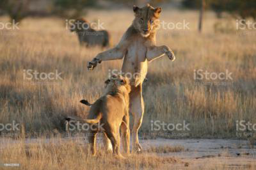

In [ ]:
im = Image.open("adult_big_cats/lion/00bdd3ff-3e60-4501-9f03-f6379207f186.jpg")
im.to_thumb(256, 256)

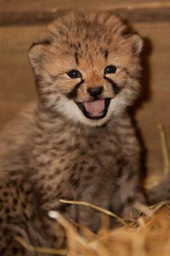

In [ ]:
im = Image.open("cub_big_cats/cheetah/01e2d00d-a157-4258-a139-f3fcf02a784a.jpg")
im.to_thumb(256, 256)

## Train Models


### Adult

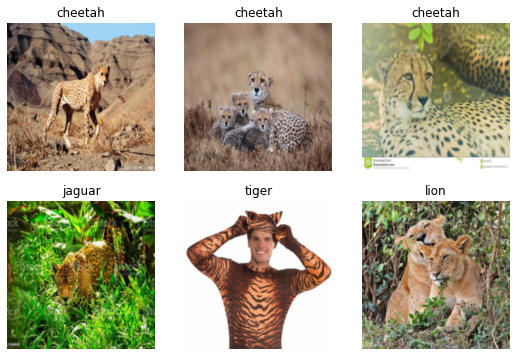

In [ ]:
adls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method="squish")]
).dataloaders("adult_big_cats")

adls.show_batch(max_n=6)

In [ ]:
alearn = vision_learner(adls, resnet18, metrics=error_rate)
alearn.fine_tune(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.752779,0.661790,0.183962,03:15


epoch,train_loss,valid_loss,error_rate,time
0,0.692634,0.548629,0.148585,04:48
1,0.480327,0.540611,0.134434,04:48
2,0.332286,0.521172,0.132075,04:39


In [ ]:
cat_type, _, probs = alearn.predict(PILImage.create("adult_big_cats/cougar/02efebd5-5959-41f1-95d9-d8babefaafbb.jpg"))
print("Big cat type: ", cat_type)
print(f"Probability {probs}")

Big cat type:  cougar
Probability TensorBase([8.1152e-06, 9.9998e-01, 3.5626e-07, 1.0638e-06, 5.2624e-06,
            4.5708e-06, 3.0231e-06])


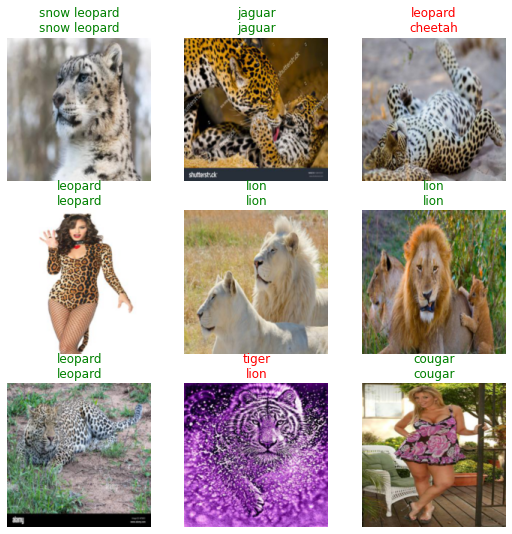

In [ ]:
alearn.show_results()

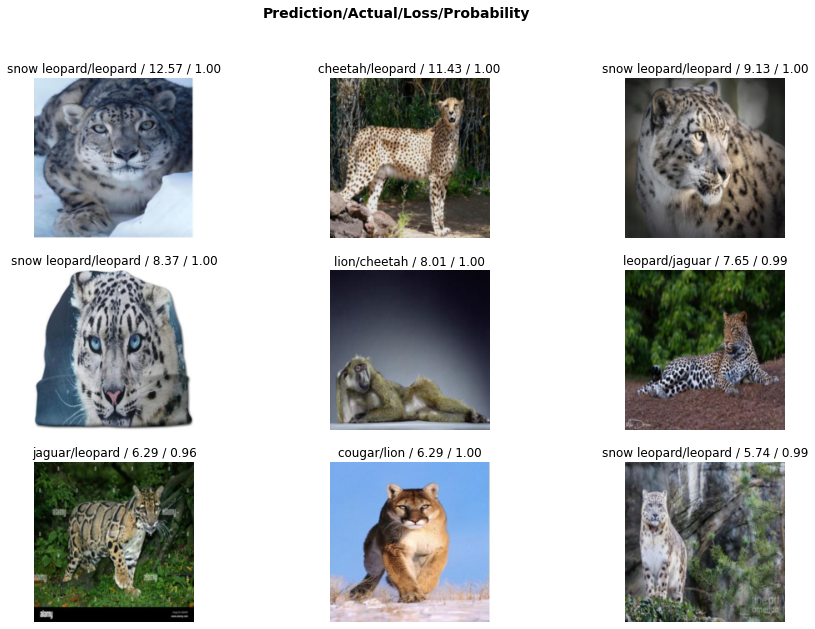

In [ ]:
interp = Interpretation.from_learner(alearn)
interp.plot_top_losses(9, figsize=(15,10))

### Cubs

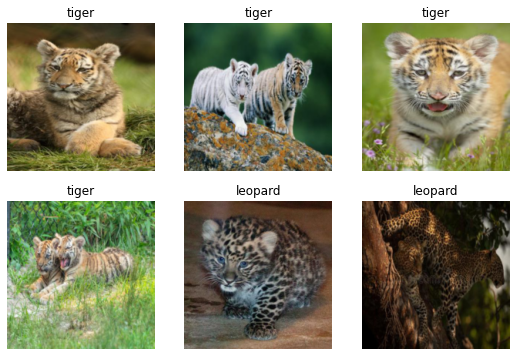

In [ ]:
cdls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method="squish")]
).dataloaders("cub_big_cats")

cdls.show_batch(max_n=6)

In [ ]:
clearn = vision_learner(cdls, resnet18, metrics=error_rate)
clearn.fine_tune(3)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,1.979961,1.010576,0.251948,03:01


epoch,train_loss,valid_loss,error_rate,time
0,0.858478,0.957785,0.225974,04:26
1,0.590116,0.958321,0.223377,04:27
2,0.411153,0.944825,0.207792,04:20


In [ ]:
cat_type, _, probs = clearn.predict(PILImage.create("cub_big_cats/jaguar/05fc09ff-3b24-4fdd-8d24-4a55efa344b2.jpg"))
print("Big cat type: ", cat_type)
print(f"Probability ")
print(probs)

Big cat type:  jaguar
Probability 
TensorBase([5.2605e-07, 2.4505e-07, 9.9944e-01, 5.0640e-04, 9.0317e-09,
            8.6626e-06, 4.3010e-05])


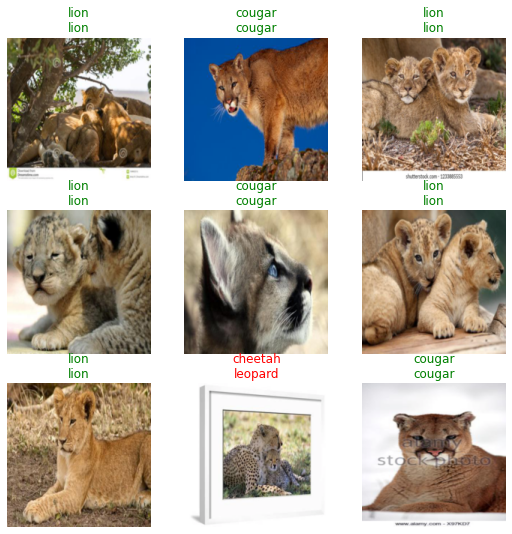

In [ ]:
clearn.show_results()

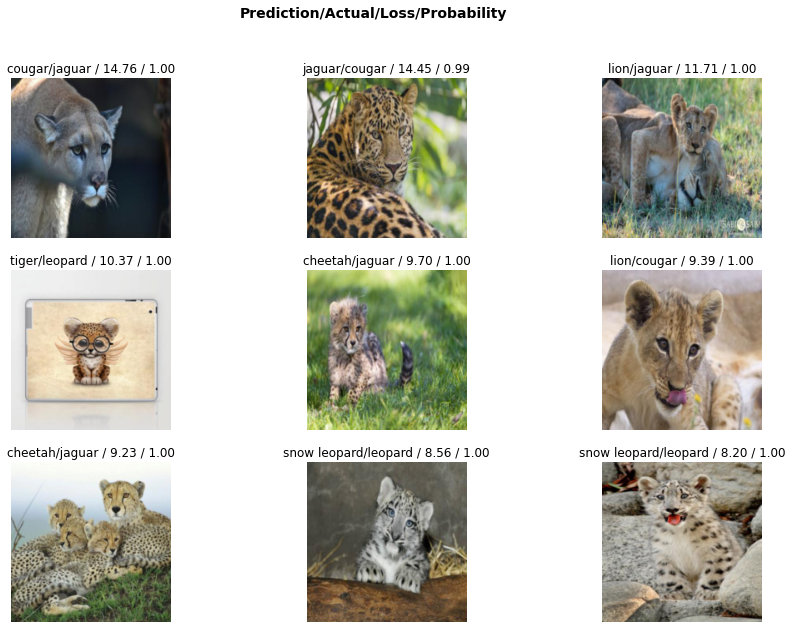

In [ ]:
interp = Interpretation.from_learner(clearn)
interp.plot_top_losses(9, figsize=(15,10))